In [ ]:
#|default_exp learner

# Learner

>fastai Learner extensions.

In [ ]:
#|export
import pickle
import warnings
from fastai.callback.core import CancelBatchException
from fastai.learner import Learner, load_learner, Recorder
from fastai.callback.schedule import *
from fastai.optimizer import Adam
from fastai.losses import MSELossFlat
from tsai.imports import *
from tsai.models.utils import *
from tsai.models.InceptionTimePlus import *

In [ ]:
#|export
@patch
def show_batch(self:Learner, **kwargs):
    self.dls.show_batch(**kwargs)

In [ ]:
#|export
@patch
def remove_all_cbs(self:Learner, max_iters=10):
    i = 0
    while len(self.cbs) > 0 and i < max_iters:  
        self.remove_cbs(self.cbs)
        i += 1
    if len(self.cbs) > 0: print(f'Learner still has {len(self.cbs)} callbacks: {self.cbs}')

In [ ]:
#|export
@patch
def one_batch(self:Learner, i, b): 
    # Fixes a bug that will be managed in the next release of fastai
    self.iter = i
#     b_on_device = tuple( e.to(device=self.dls.device) for e in b if hasattr(e, "to")) if self.dls.device is not None else b
    b_on_device = to_device(b, device=self.dls.device) if self.dls.device is not None else b
    self._split(b_on_device)
    self._with_events(self._do_one_batch, 'batch', CancelBatchException)

⚠️ Important: save_all and load_all methods are designed for small datasets only. If you are using a larger dataset, you should use the standard save and load_learner methods.

In [ ]:
#|export
@patch
def save_all(self:Learner, path='export', dls_fname='dls', model_fname='model', learner_fname='learner', verbose=False):
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)

    self.dls_type = self.dls.__class__.__name__
    if self.dls_type == "MixedDataLoaders":
        self.n_loaders = (len(self.dls.loaders), len(self.dls.loaders[0].loaders))
        dls_fnames = []
        for i,dl in enumerate(self.dls.loaders):
            for j,l in enumerate(dl.loaders):
                l = l.new(num_workers=1)
                torch.save(l, path/f'{dls_fname}_{i}_{j}.pth')
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
    else:
        dls_fnames = []
        self.n_loaders = len(self.dls.loaders)
        for i,dl in enumerate(self.dls):
            dl = dl.new(num_workers=1)
            torch.save(dl, path/f'{dls_fname}_{i}.pth')
            dls_fnames.append(f'{dls_fname}_{i}.pth')

    # Saves the model along with optimizer
    self.model_dir = path
    self.save(f'{model_fname}', with_opt=True)

    # Export learn without the items and the optimizer state for inference
    self.export(path/f'{learner_fname}.pkl')
    
    pv(f'Learner saved:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    
    
def load_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', device=None, pickle_module=pickle, verbose=False):

    if isinstance(device, int): device = torch.device('cuda', device)
    elif device is None: device = default_device()
    if device == 'cpu': cpu = True
    else: cpu = None

    path = Path(path)
    learn = load_learner(path/f'{learner_fname}.pkl', cpu=cpu, pickle_module=pickle_module)
    learn.load(f'{model_fname}', with_opt=True, device=device)

    
    if learn.dls_type == "MixedDataLoaders":
        from tsai.data.mixed import MixedDataLoader, MixedDataLoaders
        dls_fnames = []
        _dls = []
        for i in range(learn.n_loaders[0]):
            _dl = []
            for j in range(learn.n_loaders[1]):
                l = torch.load(path/f'{dls_fname}_{i}_{j}.pth', map_location=device, pickle_module=pickle_module)
                l = l.new(num_workers=0)
                l.to(device)
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
                _dl.append(l)
            _dls.append(MixedDataLoader(*_dl, path=learn.dls.path, device=device, shuffle=l.shuffle))
        learn.dls = MixedDataLoaders(*_dls, path=learn.dls.path, device=device)

    else:
        loaders = []
        dls_fnames = []
        for i in range(learn.n_loaders):
            dl = torch.load(path/f'{dls_fname}_{i}.pth', map_location=device, pickle_module=pickle_module)
            dl = dl.new(num_workers=0)
            dl.to(device)
            first(dl)
            loaders.append(dl)
            dls_fnames.append(f'{dls_fname}_{i}.pth')
        learn.dls = type(learn.dls)(*loaders, path=learn.dls.path, device=device)


    pv(f'Learner loaded:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    return learn

load_learner_all = load_all

In [ ]:
#|export
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, final_losses=True, perc=.5, **kwargs):
    
    n_values = len(self.recorder.values)
    if n_values < 2:
        print('not enough values to plot a chart')
        return
    
    # Prepare results dataframe
    train_metrics = self.train_metrics
    valid_metrics = self.valid_metrics
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    if not train_metrics and not valid_metrics:
        names = [n for n in names if "loss" in n]
    elif not train_metrics:
        names = [f"valid_{n}" if (not 'valid' in n and not 'loss' in n) else n for n in names]
    elif not valid_metrics:
        names = [f"train_{n}" if (not 'train' in n and not 'loss' in n) else n for n in names]
    results = pd.DataFrame(metrics, columns=names)
    
    # Final losses
    if final_losses:
        sel_idxs = round(n_values * perc)
        if sel_idxs < 2:
            final_losses = False
        else:
            results['train_final_loss'] = results['train_loss']
            if valid_metrics: 
                results['valid_final_loss'] = results['valid_loss']

    # set of metrics names
    names = results.columns
    metric_names = list(dict.fromkeys([n.replace('train_', '').replace('valid_', '') for n in results.columns]))
     
    # Plot
    n = len(metric_names)
    if nrows is None and ncols is None:
        if n <= 3: 
            nrows = 1
        else:
            nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6 + ncols - 1, nrows * 4 + nrows - 1)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = axs.flatten()[:n]

    for name in names:
        xs = np.arange(0, len(results))
        if name in ['train_loss', 'valid_loss']: 
            ax_idx = 0
            m = results[name].values
            title = 'losses'
        elif name in ['train_final_loss', 'valid_final_loss']: 
            ax_idx = 1
            m = results.loc[len(results) - sel_idxs:, name].values
            xs = xs[-sel_idxs:]
            title = 'final losses'
        else: 
            ax_idx = metric_names.index(name.replace("valid_", "").replace("train_", "")) + final_losses
            m = results[name].values
            title = name.replace("valid_", "").replace("train_", "")
        if 'train' in name:
            color = '#1f77b4'
            label = 'train'
        else:
            color = '#ff7f0e'
            label = 'valid' if (m != [None] * len(m)).all() else None
            axs[ax_idx].grid(color='gainsboro', linewidth=.5)
        axs[ax_idx].plot(xs, m, color=color, label=label)
        axs[ax_idx].set_xlim(xs[0], xs[-1])
        axs[ax_idx].legend(loc='best')
        axs[ax_idx].set_title(title)
        axs[ax_idx].grid(color='gainsboro', linewidth=.5)
    plt.show()
    
    
@patch
@delegates(subplots)
def plot_metrics(self: Learner, **kwargs):
    self.recorder.plot_metrics(**kwargs)

In [ ]:
#|export
all_archs_names = ['FCN', 'FCNPlus', 'InceptionTime', 'InceptionTimePlus', 'InCoordTime', 'XCoordTime', 'InceptionTimePlus17x17', 'InceptionTimePlus32x32', 
                   'InceptionTimePlus47x47', 'InceptionTimePlus62x62', 'InceptionTimeXLPlus', 'MultiInceptionTimePlus', 'MiniRocketClassifier', 
                   'MiniRocketRegressor', 'MiniRocketVotingClassifier', 'MiniRocketVotingRegressor', 'MiniRocketFeaturesPlus', 'MiniRocketPlus', 
                   'MiniRocketHead', 'InceptionRocketFeaturesPlus', 'InceptionRocketPlus', 'MLP', 'gMLP', 'MultiInputNet', 'OmniScaleCNN', 'RNN', 'LSTM', 'GRU', 
                   'RNNPlus', 'LSTMPlus', 'GRUPlus', 'RNN_FCN', 'LSTM_FCN', 'GRU_FCN', 'MRNN_FCN', 'MLSTM_FCN', 'MGRU_FCN', 'ROCKET', 'RocketClassifier', 
                   'RocketRegressor', 'ResCNN', 'ResNet', 'ResNetPlus', 'TCN', 'TSPerceiver', 'TST', 'TSTPlus', 'MultiTSTPlus', 'TSiTPlus', 'TSiTPlus', 
                   'TabFusionTransformer', 'TSTabFusionTransformer', 'TabModel', 'TabTransformer', 'GatedTabTransformer', 'TransformerModel', 'XCM', 'XCMPlus', 'xresnet1d18', 
                   'xresnet1d34', 'xresnet1d50', 'xresnet1d101', 'xresnet1d152', 'xresnet1d18_deep', 'xresnet1d34_deep', 'xresnet1d50_deep', 
                   'xresnet1d18_deeper', 'xresnet1d34_deeper', 'xresnet1d50_deeper', 'XResNet1dPlus', 'xresnet1d18plus', 'xresnet1d34plus', 
                   'xresnet1d50plus', 'xresnet1d101plus', 'xresnet1d152plus', 'xresnet1d18_deepplus', 'xresnet1d34_deepplus', 'xresnet1d50_deepplus', 
                   'xresnet1d18_deeperplus', 'xresnet1d34_deeperplus', 'xresnet1d50_deeperplus', 'XceptionTime', 'XceptionTimePlus', 'mWDN',
                   'TSSequencer', 'TSSequencerPlus']


def get_arch(arch_name):
    if arch_name == "FCN":  
        from tsai.models.FCN import FCN
        arch = FCN
    elif arch_name == "FCNPlus":  
        from tsai.models.FCNPlus import FCNPlus
        arch = FCNPlus
    elif arch_name == "InceptionTime":  
        from tsai.models.InceptionTime import InceptionTime
        arch = InceptionTime
    elif arch_name == "InceptionTimePlus":  
        from tsai.models.InceptionTimePlus import InceptionTimePlus
        arch = InceptionTimePlus
    elif arch_name == "InCoordTime":  
        from tsai.models.InceptionTimePlus import InCoordTime
        arch = InCoordTime
    elif arch_name == "XCoordTime":  
        from tsai.models.InceptionTimePlus import XCoordTime
        arch = XCoordTime
    elif arch_name == "InceptionTimePlus17x17":  
        from tsai.models.InceptionTimePlus import InceptionTimePlus17x17
        arch = InceptionTimePlus17x17
    elif arch_name == "InceptionTimePlus32x32":  
        from tsai.models.InceptionTimePlus import InceptionTimePlus32x32
        arch = InceptionTimePlus32x32
    elif arch_name == "InceptionTimePlus47x47":  
        from tsai.models.InceptionTimePlus import InceptionTimePlus47x47
        arch = InceptionTimePlus47x47
    elif arch_name == "InceptionTimePlus62x62":  
        from tsai.models.InceptionTimePlus import InceptionTimePlus62x62
        arch = InceptionTimePlus62x62
    elif arch_name == "InceptionTimeXLPlus":  
        from tsai.models.InceptionTimePlus import InceptionTimeXLPlus
        arch = InceptionTimeXLPlus
    elif arch_name == "MultiInceptionTimePlus":  
        from tsai.models.InceptionTimePlus import MultiInceptionTimePlus
        arch = MultiInceptionTimePlus
    elif arch_name == "MiniRocketClassifier":  
        from tsai.models.MINIROCKET import MiniRocketClassifier
        arch = MiniRocketClassifier
    elif arch_name == "MiniRocketRegressor":  
        from tsai.models.MINIROCKET import MiniRocketRegressor
        arch = MiniRocketRegressor
    elif arch_name == "MiniRocketVotingClassifier":  
        from tsai.models.MINIROCKET import MiniRocketVotingClassifier
        arch = MiniRocketVotingClassifier
    elif arch_name == "MiniRocketVotingRegressor":  
        from tsai.models.MINIROCKET import MiniRocketVotingRegressor
        arch = MiniRocketVotingRegressor
    elif arch_name == "MiniRocketFeaturesPlus":  
        from tsai.models.MINIROCKETPlus_Pytorch import MiniRocketFeaturesPlus
        arch = MiniRocketFeaturesPlus
    elif arch_name == "MiniRocketPlus":  
        from tsai.models.MINIROCKETPlus_Pytorch import MiniRocketPlus
        arch = MiniRocketPlus
    elif arch_name == "MiniRocketHead":  
        from tsai.models.MINIROCKETPlus_Pytorch import MiniRocketHead
        arch = MiniRocketHead
    elif arch_name == "InceptionRocketFeaturesPlus":  
        from tsai.models.MINIROCKETPlus_Pytorch import InceptionRocketFeaturesPlus
        arch = InceptionRocketFeaturesPlus
    elif arch_name == "InceptionRocketPlus":  
        from tsai.models.MINIROCKETPlus_Pytorch import InceptionRocketPlus
        arch = InceptionRocketPlus
    elif arch_name == "MLP":  
        from tsai.models.MLP import MLP
        arch = MLP
    elif arch_name == "gMLP":  
        from tsai.models.gMLP import gMLP
        arch = gMLP
    elif arch_name == "MultiInputNet":  
        from tsai.models.MultiInputNet import MultiInputNet
        arch = MultiInputNet
    elif arch_name == "OmniScaleCNN":  
        from tsai.models.OmniScaleCNN import OmniScaleCNN
        arch = OmniScaleCNN
    elif arch_name == "RNN":  
        from tsai.models.RNN import RNN
        arch = RNN
    elif arch_name == "LSTM":  
        from tsai.models.RNN import LSTM
        arch = LSTM
    elif arch_name == "GRU":  
        from tsai.models.RNN import GRU
        arch = GRU
    elif arch_name == "RNNPlus":  
        from tsai.models.RNNPlus import RNNPlus
        arch = RNNPlus
    elif arch_name == "LSTMPlus":  
        from tsai.models.RNNPlus import LSTMPlus
        arch = LSTMPlus
    elif arch_name == "GRUPlus":  
        from tsai.models.RNNPlus import GRUPlus
        arch = GRUPlus
    elif arch_name == "RNN_FCN":  
        from tsai.models.RNN_FCN import RNN_FCN
        arch = RNN_FCN
    elif arch_name == "LSTM_FCN":  
        from tsai.models.RNN_FCN import LSTM_FCN
        arch = LSTM_FCN
    elif arch_name == "GRU_FCN":  
        from tsai.models.RNN_FCN import GRU_FCN
        arch = GRU_FCN
    elif arch_name == "MRNN_FCN":  
        from tsai.models.RNN_FCN import MRNN_FCN
        arch = MRNN_FCN
    elif arch_name == "MLSTM_FCN":  
        from tsai.models.RNN_FCN import MLSTM_FCN
        arch = MLSTM_FCN
    elif arch_name == "MGRU_FCN":  
        from tsai.models.RNN_FCN import MGRU_FCN
        arch = MGRU_FCN
    elif arch_name == "RNN_FCNPlus":  
        from tsai.models.RNN_FCNPlus import RNN_FCNPlus
        arch = RNN_FCNPlus
    elif arch_name == "LSTM_FCNPlus":  
        from tsai.models.RNN_FCNPlus import LSTM_FCNPlus
        arch = LSTM_FCNPlus
    elif arch_name == "GRU_FCNPlus":  
        from tsai.models.RNN_FCNPlus import GRU_FCNPlus
        arch = GRU_FCNPlus
    elif arch_name == "MRNN_FCNPlus":  
        from tsai.models.RNN_FCNPlus import MRNN_FCNPlus
        arch = MRNN_FCNPlus
    elif arch_name == "MLSTM_FCNPlus":  
        from tsai.models.RNN_FCNPlus import MLSTM_FCNPlus
        arch = MLSTM_FCNPlus
    elif arch_name == "MGRU_FCNPlus":  
        from tsai.models.RNN_FCNPlus import MGRU_FCNPlus
        arch = MGRU_FCNPlus
    elif arch_name == "PatchTST":  
        from tsai.models.PatchTST import PatchTST
        arch = PatchTST
    elif arch_name == "ROCKET":  
        from tsai.models.ROCKET import ROCKET
        arch = ROCKET
    elif arch_name == "RocketClassifier":  
        from tsai.models.ROCKET import RocketClassifier
        arch = RocketClassifier
    elif arch_name == "RocketRegressor":  
        from tsai.models.ROCKET import RocketRegressor
        arch = RocketRegressor
    elif arch_name == "ResCNN":  
        from tsai.models.ResCNN import ResCNN
        arch = ResCNN
    elif arch_name == "ResNet":  
        from tsai.models.ResNet import ResNet
        arch = ResNet
    elif arch_name == "ResNetPlus":  
        from tsai.models.ResNetPlus import ResNetPlus
        arch = ResNetPlus
    elif arch_name == "TCN":  
        from tsai.models.TCN import TCN
        arch = TCN
    elif arch_name == "TSPerceiver":  
        from tsai.models.TSPerceiver import TSPerceiver
        arch = TSPerceiver
    elif arch_name == "TST":  
        from tsai.models.TST import TST
        arch = TST
    elif arch_name == "TSTPlus":  
        from tsai.models.TSTPlus import TSTPlus
        arch = TSTPlus
    elif arch_name == "MultiTSTPlus":  
        from tsai.models.TSTPlus import MultiTSTPlus
        arch = MultiTSTPlus
    elif arch_name == "TSiT":  
        from tsai.models.TSiTPlus import TSiT
        arch = TSiT
    elif arch_name == "TSiTPlus":  
        from tsai.models.TSiTPlus import TSiTPlus
        arch = TSiTPlus
    elif arch_name == "TSSequencer":  
        from tsai.models.TSiTPlus import TSSequencer
        arch = TSSequencer
    elif arch_name == "TSSequencerPlus":  
        from tsai.models.TSSequencerPlus import TSSequencerPlus
        arch = TSSequencerPlus
    elif arch_name == "TabFusionTransformer":  
        from tsai.models.TabFusionTransformer import TabFusionTransformer
        arch = TabFusionTransformer
    elif arch_name == "TSTabFusionTransformer":  
        from tsai.models.TabFusionTransformer import TSTabFusionTransformer
        arch = TSTabFusionTransformer
    elif arch_name == "TabModel":  
        from tsai.models.TabModel import TabModel
        arch = TabModel
    elif arch_name == "TabTransformer":  
        from tsai.models.TabTransformer import TabTransformer
        arch = TabTransformer
    elif arch_name == "GatedTabTransformer":  
        from tsai.models.GatedTabTransformer import GatedTabTransformer
        arch = GatedTabTransformer
    elif arch_name == "TransformerModel":  
        from tsai.models.TransformerModel import TransformerModel
        arch = TransformerModel
    elif arch_name == "XCM":  
        from tsai.models.XCM import XCM
        arch = XCM
    elif arch_name == "XCMPlus":  
        from tsai.models.XCMPlus import XCMPlus
        arch = XCMPlus
    elif arch_name == "XResNet1d":  
        from tsai.models.XResNet1d import XResNet1d
        arch = XResNet1d
    elif arch_name == "xresnet1d18":  
        from tsai.models.XResNet1d import xresnet1d18
        arch = xresnet1d18
    elif arch_name == "xresnet1d34":  
        from tsai.models.XResNet1d import xresnet1d34
        arch = xresnet1d34
    elif arch_name == "xresnet1d50":  
        from tsai.models.XResNet1d import xresnet1d50
        arch = xresnet1d50
    elif arch_name == "xresnet1d101":  
        from tsai.models.XResNet1d import xresnet1d101
        arch = xresnet1d101
    elif arch_name == "xresnet1d152":  
        from tsai.models.XResNet1d import xresnet1d152
        arch = xresnet1d152
    elif arch_name == "xresnet1d18_deep":  
        from tsai.models.XResNet1d import xresnet1d18_deep
        arch = xresnet1d18_deep
    elif arch_name == "xresnet1d34_deep":  
        from tsai.models.XResNet1d import xresnet1d34_deep
        arch = xresnet1d34_deep
    elif arch_name == "xresnet1d50_deep":  
        from tsai.models.XResNet1d import xresnet1d50_deep
        arch = xresnet1d50_deep
    elif arch_name == "xresnet1d18_deeper":  
        from tsai.models.XResNet1d import xresnet1d18_deeper
        arch = xresnet1d18_deeper
    elif arch_name == "xresnet1d34_deeper":  
        from tsai.models.XResNet1d import xresnet1d34_deeper
        arch = xresnet1d34_deeper
    elif arch_name == "xresnet1d50_deeper":  
        from tsai.models.XResNet1d import xresnet1d50_deeper
        arch = xresnet1d50_deeper
    elif arch_name == "XResNet1dPlus":  
        from tsai.models.XResNet1dPlus import XResNet1dPlus
        arch = XResNet1dPlus
    elif arch_name == "xresnet1d18plus":  
        from tsai.models.XResNet1dPlus import xresnet1d18plus
        arch = xresnet1d18plus
    elif arch_name == "xresnet1d34plus":  
        from tsai.models.XResNet1dPlus import xresnet1d34plus
        arch = xresnet1d34plus
    elif arch_name == "xresnet1d50plus":  
        from tsai.models.XResNet1dPlus import xresnet1d50plus
        arch = xresnet1d50plus
    elif arch_name == "xresnet1d101plus":  
        from tsai.models.XResNet1dPlus import xresnet1d101plus
        arch = xresnet1d101plus
    elif arch_name == "xresnet1d152plus":  
        from tsai.models.XResNet1dPlus import xresnet1d152plus
        arch = xresnet1d152plus
    elif arch_name == "xresnet1d18_deepplus":  
        from tsai.models.XResNet1dPlus import xresnet1d18_deepplus
        arch = xresnet1d18_deepplus
    elif arch_name == "xresnet1d34_deepplus":  
        from tsai.models.XResNet1dPlus import xresnet1d34_deepplus
        arch = xresnet1d34_deepplus
    elif arch_name == "xresnet1d50_deepplus":  
        from tsai.models.XResNet1dPlus import xresnet1d50_deepplus
        arch = xresnet1d50_deepplus
    elif arch_name == "xresnet1d18_deeperplus":  
        from tsai.models.XResNet1dPlus import xresnet1d18_deeperplus
        arch = xresnet1d18_deeperplus
    elif arch_name == "xresnet1d34_deeperplus":  
        from tsai.models.XResNet1dPlus import xresnet1d34_deeperplus
        arch = xresnet1d34_deeperplus
    elif arch_name == "xresnet1d50_deeperplus":  
        from tsai.models.XResNet1dPlus import xresnet1d50_deeperplus
        arch = xresnet1d50_deeperplus
    elif arch_name == "XceptionTime":  
        from tsai.models.XceptionTime import XceptionTime
        arch = XceptionTime
    elif arch_name == "XceptionTimePlus":  
        from tsai.models.XceptionTimePlus import XceptionTimePlus
        arch = XceptionTimePlus
    elif arch_name == "mWDN":  
        from tsai.models.mWDN import mWDN
        arch = mWDN
    else: print(f"please, confirm the name of the architecture ({arch_name})")
    assert arch.__name__ == arch_name
    return arch

In [ ]:
arch_name = 'InceptionTimePlus'
test_eq(get_arch('InceptionTimePlus').__name__, arch_name)

In [ ]:
#|export
@delegates(build_ts_model)
def ts_learner(dls, arch=None, c_in=None, c_out=None, seq_len=None, d=None, splitter=trainable_params,
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95), 
               train_metrics=False, valid_metrics=True, **kwargs)->Learner:

    if isinstance(arch, nn.Module): 
        model = arch
        if kwargs: 
            warnings.warn("You have passed kwargs to a model that is already intantiated. They will not have any effect.", UserWarning)
    else:
        if arch is None: arch = InceptionTimePlus
        elif isinstance(arch, str): arch = get_arch(arch)
        model = build_ts_model(arch, dls=dls, c_in=c_in, c_out=c_out, seq_len=seq_len, d=d, **kwargs)
    if hasattr(model, "backbone") and hasattr(model, "head"):
        splitter = ts_splitter
    if loss_func is None:
        if hasattr(dls, 'loss_func'): loss_func = dls.loss_func
        elif hasattr(dls, 'train_ds') and hasattr(dls.train_ds, 'loss_func'): loss_func = dls.train_ds.loss_func
        elif hasattr(dls, 'cat') and not dls.cat: loss_func = MSELossFlat()
        
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path, splitter=splitter,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms, )

    if hasattr(learn, "recorder"):
            learn.recorder.train_metrics = train_metrics
            learn.recorder.valid_metrics = valid_metrics if len(dls.valid) > 0 else False
    
    # keep track of args for loggers
    store_attr('arch', self=learn)

    return learn

In [ ]:
#|export
@delegates(build_tsimage_model)
def tsimage_learner(dls, arch=None, pretrained=False,
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               **kwargs):

    if arch is None: 
        from tsai.models.XResNet1d import xresnet34
        arch = xresnet34
    elif isinstance(arch, str): arch = get_arch(arch)
    model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, **kwargs)
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

    # keep track of args for loggers
    store_attr('arch', self=learn)

    return learn

In [ ]:
#|export
@patch
def decoder(self:Learner, o): return L([self.dls.decodes(oi) for oi in o])

In [ ]:
from tsai.data.core import *
from tsai.data.external import get_UCR_data
from tsai.models.FCNPlus import FCNPlus

In [ ]:
X, y, splits = get_UCR_data('OliveOil', verbose=True, split_data=False)
tfms  = [None, [TSCategorize()]]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms)
learn = ts_learner(dls, FCNPlus)
for p in learn.model.parameters():
    p.requires_grad=False
test_eq(count_parameters(learn.model), 0)
learn.freeze()
test_eq(count_parameters(learn.model), 1540)
learn.unfreeze()
test_eq(count_parameters(learn.model), 264580)

learn = ts_learner(dls, 'FCNPlus')
for p in learn.model.parameters():
    p.requires_grad=False
test_eq(count_parameters(learn.model), 0)
learn.freeze()
test_eq(count_parameters(learn.model), 1540)
learn.unfreeze()
test_eq(count_parameters(learn.model), 264580)

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : (#30) [0,1,2,3,4,5,6,7,8,9...] (#30) [30,31,32,33,34,35,36,37,38,39...] 



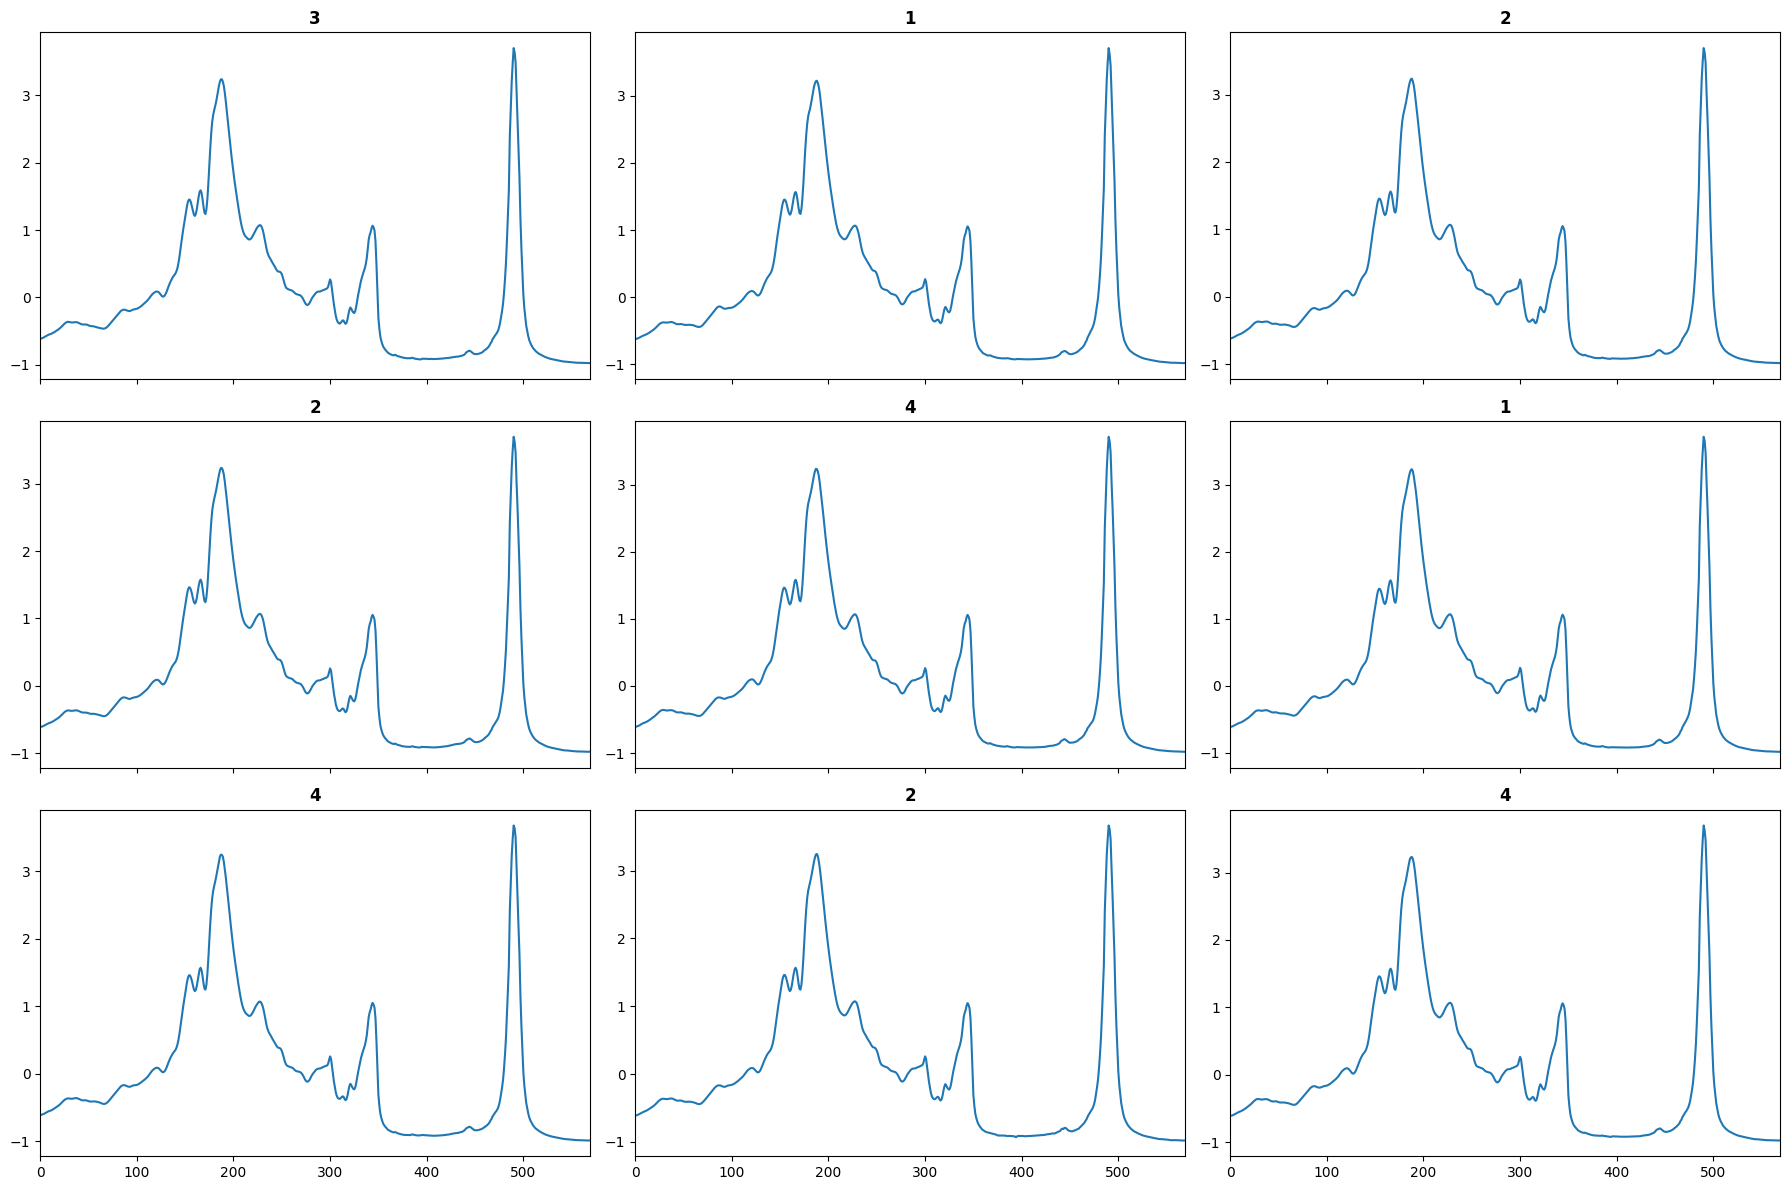

In [ ]:
learn.show_batch();

In [ ]:
from fastai.metrics import accuracy
from tsai.data.preprocessing import TSRobustScale

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.326558,0.433333,1.365817,0.300000,00:02
1,1.324806,0.433333,1.363004,0.300000,00:01


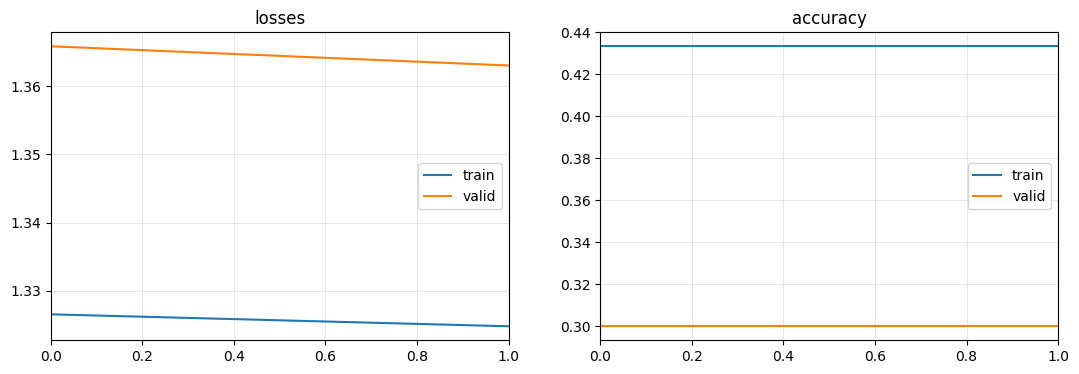

In [ ]:
X, y, splits = get_UCR_data('OliveOil', split_data=False)
tfms  = [None, TSClassification()]
batch_tfms = TSRobustScale()
dls = get_ts_dls(X, y, tfms=tfms, splits=splits, batch_tfms=batch_tfms)
learn = ts_learner(dls, FCNPlus, metrics=accuracy, train_metrics=True)
learn.fit_one_cycle(2)
learn.plot_metrics()

In [ ]:
if not os.path.exists("./models"): os.mkdir("./models")
if not os.path.exists("./data"): os.mkdir("./data")
np.save("data/X_test.npy", X[splits[1]])
np.save("data/y_test.npy", y[splits[1]])
learn.export("./models/test.pth")

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/018_learner.ipynb saved at 2023-02-20 14:20:54
Correct notebook to script conversion! 😃
Monday 20/02/23 14:20:57 CET
